***
# XGBoost vs Keras
### Dataset : Bank Customer Targeting from SIGNATE 
***
1. What is SIGNATE
1. What is XGBoost
1. Predict by XGBoost
1. Predict by Keras with GridSearchCV
1. Predict by Keras
1. 感想

***
### 1. What is SIGNATE
***
**Kaggle**<br>
Kaggleは企業や研究者がデータを投稿し、世界中の統計家やデータ分析家がその最適モデルを競い合う、<br>
予測モデリング及び分析手法関連プラットフォーム及びその運営会社である。(wikipedia)<br>
<br>
**SIGNATE**<br>
元DeepAnalytics。日本版Kaggle。<br>
今回はそのなかで「銀行の顧客ターゲティング」に挑戦。<br>
<br>
**使用するデータ**<br>
使用するデータは、ある銀行の顧客属性データおよび、過去のキャンペーンでの接触情報、などで、<br>
これらのデータを元に、当該のキャンペーンの結果、口座を開設したかどうかを予測。<br>
使用するデータは27,128名の顧客データとキャンペーンの結果（口座開設の有無）。<br>

***
### 2. What is XGBoost
***
XGBoost = e**X**treme **G**radient **B**oosting<br>
弱学習器に決定木を用いるアンサンブル学習<br>
<br>
教師あり学習は主に2パターン。<br>
1. 単一の学習器の性能を向上させる
2. 個々に学習した複数の学習器を何らかの形で融合させて汎化能力を向上させる方法 → アンサンブル学習

アンサンブル学習は簡単に言えば、多数決を取るイメージ。<br>
そのアンサンブル学習の手法の1つがブースティング。逐次的に弱学習器を構築し、予測モデルを生成する。<br>
前の学習器が誤分類したデータを優先的に正しく分類できるように学習していく重み付きの多数決。<br>
<br>
ブースティングにおいて、弱学習器を構築する際に損失関数の最小化に勾配降下法を用いるものをGradient Boostingと呼ぶ。<br>
そのGradient BoostingをC++で実装し、高速化したものがXGBoost。（弱学習器は決定木）<br>
**Kaggle**では、2015年に出された問題29問のうち、17問がXGBoostを用いたモデルが１位となっている。（DCNN的な...?）<br>
<br>
XGBoostの利点は、下記らしい。<br>
1. 欠損値が多いなどのスパースなデータに対して、事前に木の分岐の方向を決めるアルゴリズムを採用している。
2. 並列分散処理により、モデルの探索を高速化している。
3. CPU外でも学習が回せるため、大規模なデータも処理できる。

***
### 3. Predict by XGBoost
***

In [1]:
import math
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.layers.core import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model
from keras.models import Sequential
from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# csvファイルを読み込む　→　idカラムを削除
df = pd.read_csv('remake_train.csv')
df = df.drop(["id"], axis=1)

# 説明変数（yカラムを削除）
df_except_y = df.drop(["y"], axis=1)
X = df_except_y.as_matrix()


# 目的変数（yカラムを抽出）
y = df['y'].as_matrix() # one-hotにしなくていい

# print
print('Data  :  ', type(X), X.shape)
print('Target  :  ', type(y), y.shape)

Data  :   <class 'numpy.ndarray'> (27128, 16)
Target  :   <class 'numpy.ndarray'> (27128,)


In [3]:
# 説明変数一覧
df_except_y

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,39,2,2,3,0,1756,1,0,1,3,4,939,1,-1,0,4
1,51,3,2,2,0,1443,0,0,1,18,2,172,10,-1,0,4
2,36,5,3,4,0,436,0,0,1,13,4,567,1,595,2,1
3,63,6,2,3,0,474,0,0,1,25,1,423,1,-1,0,4
4,31,5,3,4,0,354,0,0,1,30,4,502,1,9,2,3
5,29,2,3,3,0,260,1,0,3,2,6,707,14,-1,0,4
6,37,8,2,3,0,52,1,0,1,6,9,908,1,185,9,3
7,32,10,3,3,0,230,1,0,1,18,5,442,1,266,8,1
8,31,1,3,3,0,0,1,0,1,7,5,895,2,295,2,1
9,32,7,3,4,0,1815,0,0,2,10,8,235,1,102,2,1


In [4]:
# 説明変数の内容
column_values = pd.Series(np.arange(1, 17))
header_values = pd.Series(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'])
datatype_values = pd.Series(['int', 'varchar', 'varchar', 'varchar', 'varchar', 'int',
                   'varchar', 'varchar', 'varchar', 'int', 'char', 'int', 'int', 'int', 'int', 'varchar'])
description_values = pd.Series(['年齢', '職種', '未婚/既婚', '教育水準', '債務不履行があるか（yes, no）', 
                      '年間平均残高（€）', '住宅ローン（yes, no）', '個人ローン（yes, no）', '連絡方法', '最終接触日', 
                      '最終接触月', '最終接触時間（秒）', '現キャンペーンにおける接触回数', 
                      '経過日数：前キャンペーン接触後の日数', '接触実績：現キャンペーン以前までに顧客に接触した回数', 
                      '前回のキャンペーンの成果'])
my_dict = {'カラム':column_values, 'ヘッダ名称':header_values, 'データ型':datatype_values, '説明':description_values}
my_df = pd.DataFrame({'カラム':column_values, 'ヘッダ名称':header_values, 'データ型':datatype_values, '説明':description_values})
my_df

,カラム,データ型,ヘッダ名称,説明
0,1,int,age,年齢
1,2,varchar,job,職種
2,3,varchar,marital,未婚/既婚
3,4,varchar,education,教育水準
4,5,varchar,default,"債務不履行があるか（yes, no）"
5,6,int,balance,年間平均残高（€）
6,7,varchar,housing,"住宅ローン（yes, no）"
7,8,varchar,loan,"個人ローン（yes, no）"
8,9,varchar,contact,連絡方法
9,10,int,day,最終接触日


In [5]:
#　trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18989, 16) (8139, 16) (18989,) (8139,)


In [6]:
# GridSearchで総当たりするパラメータ
params = {"learning_rate":[0.1,0.3,0.5],
          "max_depth": [2,3,5,10],
          "subsample":[0.5,0.8,0.9,1],
          "colsample_bytree": [0.5,1.0],
         }

In [7]:
# xgboostモデルの作成
# clf = xgb.XGBClassifier()

In [8]:
# ハイパーパラメータ探索
# clf_cv = GridSearchCV(clf, params, cv = 10, scoring= 'roc_auc', n_jobs =-1, verbose=1)
# clf_cv.fit(X_train, y_train)
# print(clf_cv.best_params_, clf_cv.best_score_)

/usr/local/bin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/bin/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)<br>
 <br>
Fitting 10 folds for each of 96 candidates, totalling 960 fits<br>
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s<br>
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.2s<br>
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.0min<br>
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.5min<br>
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  3.3min finished<br>

In [9]:
# 改めて最適パラメータで学習
# clf = xgb.XGBClassifier(**clf_cv.best_params_)
# clf.fit(X_train, y_train)

# 学習モデルの保存、読み込み
# pickle.dump(clf, open("xgboost_bank.pkl", "wb"))

In [10]:
# モデルをロード
clf = pickle.load(open("xgboost_bank.pkl", "rb"))

In [45]:
# 学習モデルの評価
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[6945  212]
 [ 568  414]]
             precision    recall  f1-score   support

          0       0.92      0.97      0.95      7157
          1       0.66      0.42      0.51       982

avg / total       0.89      0.90      0.89      8139



/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


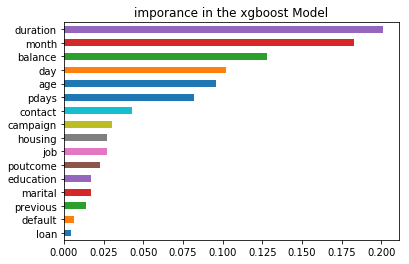

In [12]:
# feature importance のプロット
importances = pd.Series(clf.feature_importances_, index = df_except_y.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [36]:
print('test acc:', accuracy_score(y_test, pred))

test acc: 0.904165130851456


Text(42,0.5,'prediction')

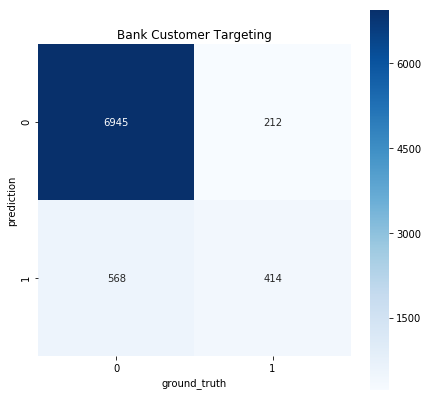

In [38]:
# seaborn.heatmap を使ってプロットする
import seaborn as sns
conf_mat = confusion_matrix(y_test, pred)

heat_index = list("01")
heat_columns = list("01")
heat = pd.DataFrame(conf_mat, index=heat_index, columns=heat_columns)

fig = plt.figure(figsize = (7,7))
sns.heatmap(heat, annot=True, square=True, fmt='.0f', cmap="Blues")
plt.title('Bank Customer Targeting')
plt.xlabel('ground_truth')
plt.ylabel('prediction')

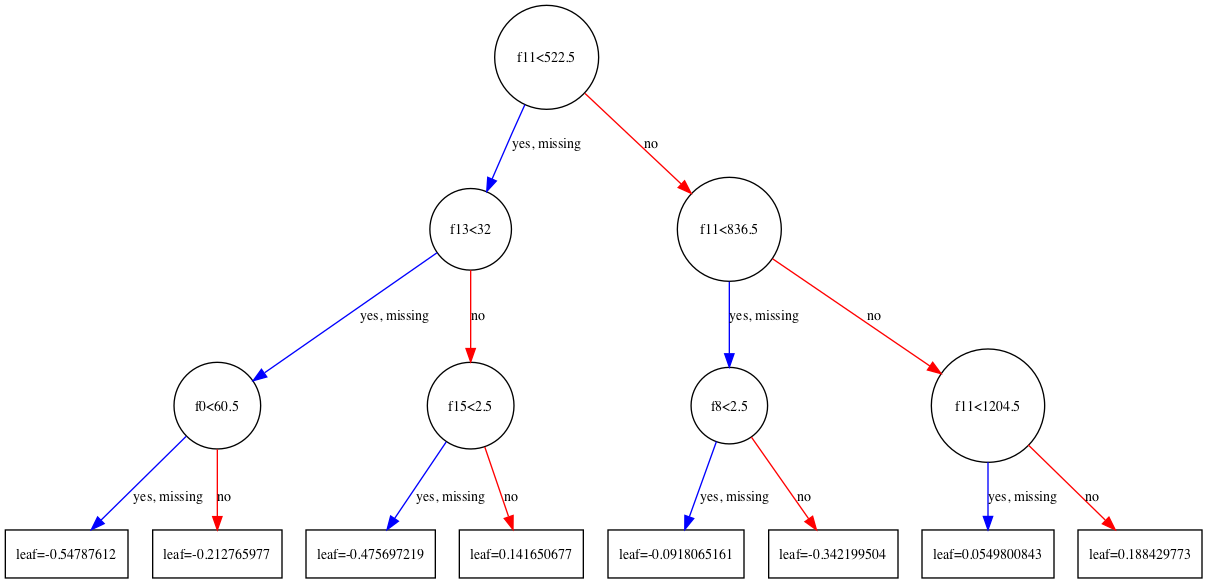

In [57]:
# tree を描画
% matplotlib inline
graph1 = xgb.to_graphviz(clf)
graph1.format = 'png'
#graph1.render('tree1')

from IPython.display import Image, display_png
display_png(Image('tree1.png'))

***
### 4. Predict by Keras with GridSearchCV
***

In [32]:
# csvファイルを読み込む
df = pd.read_csv('remake_train.csv')
df = df.drop(["id"], axis=1)

# 説明変数
df_except_y = df.drop(["y"], axis=1)
X = df_except_y.as_matrix()
input_dim = X.shape[-1]

# 目的変数
y = df['y'].as_matrix()
num_classes = 2

#　trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [15]:
# build model
def bank_model(activation="relu", optimizer="adam", out_dim=100):
    model = Sequential()
    model.add(Dense(out_dim, input_dim=input_dim, activation=activation))
    model.add(Dense(out_dim, activation=activation))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [16]:
# parameter for GridSearch
activation = ["relu", "sigmoid"]
optimizer = ["adam", "adagrad"]
out_dim = [100, 200]
# nb_epoch = [10, 25]
# batch_size = [5, 10]

In [17]:
model = KerasClassifier(build_fn=bank_model, verbose=1)
param_grid = dict(activation=activation, 
                  optimizer=optimizer, 
                  out_dim=out_dim) # , 
                  # nb_epoch=nb_epoch, 
                  # batch_size=batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring= 'roc_auc', n_jobs =-1,verbose=1)

In [18]:
grid_result = grid.fit(X_train, y_train, nb_epoch=10, batch_size=10)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims insteadWARNING:tensorflow:From /anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1108: calling reduce_mean (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
17090/17090 [==============================] - 9s - loss: 1.8675 - acc: 0.8839

17090/17090 [==============================] - 7s - loss: 1.8636 - acc: 0.8844        
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 1.8608 - acc: 0.8846     
Epoch 4/10
 1230/17090 [=>............................] - ETA: 6s - loss: 1.8608 - acc: 0.8846
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 1.8674 - acc: 0.8841     
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 1.8636 - acc: 0.8844     
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 1.8608 - acc: 0.8846     
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 1.8636 - acc: 0.8844     
Epoch 6/10
17090/17090 [==============================] - 7s - loss: 1.8608 - acc: 0.8846     
Epoch 6/10
17090/17090 [==============================] - 7s - loss: 1.8608 - acc: 0.8846     
Epoch 6/10
17090/17090 [==============================] - 7s - loss: 1.8674 - acc: 0.8841     
Epoch 7/10
17090/17090 [==============================] - 

17090/17090 [==============================] - 11s - loss: 1.9372 - acc: 0.8795    
Epoch 2/10
 7940/17090 [============>.................] - ETA: 7s - loss: 1.9576 - acc: 0.8780
Epoch 2/10
 4730/17090 [=======>......................] - ETA: 7s - loss: 1.8265 - acc: 0.8867
Epoch 2/10
17090/17090 [==============================] - 10s - loss: 1.8580 - acc: 0.8847    
Epoch 3/10
17090/17090 [==============================] - 10s - loss: 1.8363 - acc: 0.8861    
Epoch 3/10
17090/17090 [==============================] - 10s - loss: 1.8580 - acc: 0.8847    
Epoch 4/10
17090/17090 [==============================] - 10s - loss: 1.8363 - acc: 0.8861    
Epoch 4/10
17090/17090 [==============================] - 10s - loss: 1.8608 - acc: 0.8846    
Epoch 4/10
17090/17090 [==============================] - 10s - loss: 1.8363 - acc: 0.8861    
Epoch 5/10
17090/17090 [==============================] - 10s - loss: 1.8636 - acc: 0.8844    
Epoch 5/10
17090/17090 [==============================] - 10s

 1270/17090 [=>............................] - ETA: 8s - loss: 2.1448 - acc: 0.8669
Epoch 7/10
11150/17090 [==================>...........] - ETA: 3s - loss: 1.8720 - acc: 0.8839
Epoch 7/10
 6220/17090 [=========>....................] - ETA: 5s - loss: 1.9461 - acc: 0.8793
Epoch 7/10
17090/17090 [==============================] - 8s - loss: 1.8608 - acc: 0.8846     
Epoch 8/10
17091/17091 [==============================] - 8s - loss: 1.8663 - acc: 0.8842     
Epoch 8/10

17090/17090 [==============================] - 8s - loss: 1.8608 - acc: 0.8846     
Epoch 9/10
17090/17090 [==============================] - 8s - loss: 1.8806 - acc: 0.8833     
Epoch 9/10
17091/17091 [==============================] - 8s - loss: 1.8663 - acc: 0.8842     
Epoch 9/10
17090/17090 [==============================] - 8s - loss: 1.8608 - acc: 0.8846     
Epoch 10/10
11050/17091 [==================>...........] - ETA: 3s - loss: 1.8481 - acc: 0.8853
Epoch 10/10
16960/17090 [============================>.] - 

17090/17090 [==============================] - 6s - loss: 1.8636 - acc: 0.8844     
Epoch 5/10
  760/17090 [>.............................] - ETA: 5s - loss: 1.8239 - acc: 0.8868
Epoch 4/10
17090/17090 [==============================] - 6s - loss: 1.8674 - acc: 0.8841     
Epoch 5/10
17090/17090 [==============================] - 6s - loss: 1.8636 - acc: 0.8844     
Epoch 6/10
17090/17090 [==============================] - 6s - loss: 1.8608 - acc: 0.8846     
Epoch 5/10
10600/17090 [=================>............] - ETA: 2s - loss: 1.8536 - acc: 0.8850
Epoch 6/10
17090/17090 [==============================] - 6s - loss: 1.8608 - acc: 0.8846     
Epoch 7/10
17090/17090 [==============================] - 6s - loss: 1.8636 - acc: 0.8844     
Epoch 7/10
17090/17090 [==============================] - 6s - loss: 1.8608 - acc: 0.8846     
Epoch 6/10
17090/17090 [==============================] - 6s - loss: 1.8674 - acc: 0.8841     
Epoch 7/10
16990/17090 [============================>.] - ETA

17090/17090 [==============================] - 8s - loss: 1.8608 - acc: 0.8846     
Epoch 2/10
 8110/17090 [=============>................] - ETA: 4s - loss: 1.8662 - acc: 0.8842
Epoch 3/10
17090/17090 [==============================] - 8s - loss: 1.8363 - acc: 0.8861     
Epoch 3/10
17090/17090 [==============================] - 7s - loss: 1.8636 - acc: 0.8844     
Epoch 3/10
17090/17090 [==============================] - 8s - loss: 1.8608 - acc: 0.8846     
Epoch 3/10
17090/17090 [==============================] - 8s - loss: 1.8580 - acc: 0.8847     
Epoch 4/10
17090/17090 [==============================] - 8s - loss: 1.8363 - acc: 0.8861     
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 1.8636 - acc: 0.8844     
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 1.8608 - acc: 0.8846     
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 1.8580 - acc: 0.8847     
Epoch 5/10
17090/17090 [==============================] - 7s 

17090/17090 [==============================] - 7s - loss: 0.3026 - acc: 0.8826     
Epoch 2/10
 7930/17090 [============>.................] - ETA: 5s - loss: 0.3131 - acc: 0.8813
Epoch 2/10
17090/17090 [==============================] - 7s - loss: 0.2875 - acc: 0.8861     
Epoch 3/10
15010/17090 [=========================>....] - ETA: 1s - loss: 0.3001 - acc: 0.8865
Epoch 3/10
 2970/17090 [====>.........................] - ETA: 6s - loss: 0.2647 - acc: 0.8980
Epoch 2/10
17090/17090 [==============================] - 7s - loss: 0.2853 - acc: 0.8882     
Epoch 4/10
10200/17090 [================>.............] - ETA: 2s - loss: 0.2751 - acc: 0.8911
Epoch 4/10
13810/17090 [=======================>......] - ETA: 1s - loss: 0.2842 - acc: 0.8885
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 0.2808 - acc: 0.8872     
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 0.2838 - acc: 0.8877     
Epoch 5/10
17090/17090 [==============================] - 7s 

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.3min


17090/17090 [==============================] - 7s - loss: 0.3041 - acc: 0.8839     
Epoch 2/10
17090/17090 [==============================] - 7s - loss: 0.3007 - acc: 0.8840     
Epoch 2/10
17090/17090 [==============================] - 8s - loss: 0.3061 - acc: 0.8854     
Epoch 2/10
17090/17090 [==============================] - 7s - loss: 0.2879 - acc: 0.8861     
Epoch 3/10
17090/17090 [==============================] - 7s - loss: 0.2893 - acc: 0.8854     
Epoch 3/10
 5780/17090 [=========>....................] - ETA: 4s - loss: 0.2812 - acc: 0.8824
Epoch 2/10
17090/17090 [==============================] - 7s - loss: 0.2848 - acc: 0.8853     
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 0.2846 - acc: 0.8853     
Epoch 4/10
17090/17090 [==============================] - 7s - loss: 0.2898 - acc: 0.8856     
Epoch 3/10
13190/17090 [======================>.......] - ETA: 1s - loss: 0.2826 - acc: 0.8864
Epoch 4/10
17090/17090 [==============================] - 7s 

17090/17090 [==============================] - 8s - loss: 0.2749 - acc: 0.8858     
Epoch 10/10
 2190/17090 [==>...........................] - ETA: 7s - loss: 0.2761 - acc: 0.8826
Epoch 10/10
17090/17090 [==============================] - 8s - loss: 0.2735 - acc: 0.8887     
Epoch 9/10
17090/17090 [==============================] - 8s - loss: 0.2765 - acc: 0.8895     
Epoch 10/10
17090/17090 [==============================] - 8s - loss: 0.2774 - acc: 0.8878     
Epoch 10/10
17090/17090 [==============================] - 10s - loss: 0.3025 - acc: 0.8844    
Epoch 2/10
17090/17090 [==============================] - 7s - loss: 0.2877 - acc: 0.8874     
Epoch 3/10
 7910/17090 [============>.................] - ETA: 6s - loss: 0.3133 - acc: 0.8832
Epoch 2/10
17090/17090 [==============================] - 8s - loss: 0.2813 - acc: 0.8882     
Epoch 4/10
 9070/17090 [==============>...............] - ETA: 4s - loss: 0.2975 - acc: 0.8830
Epoch 4/10
 9180/17090 [===============>..............] -

17090/17090 [==============================] - 9s - loss: 0.2794 - acc: 0.8858     
Epoch 7/10
17091/17091 [==============================] - 9s - loss: 0.2802 - acc: 0.8878     
Epoch 5/10
17090/17090 [==============================] - 9s - loss: 0.2822 - acc: 0.8857     
Epoch 6/10
17090/17090 [==============================] - 9s - loss: 0.2794 - acc: 0.8870     
Epoch 8/10
17091/17091 [==============================] - 9s - loss: 0.2816 - acc: 0.8875     
Epoch 6/10
 8210/17090 [=============>................] - ETA: 4s - loss: 0.2707 - acc: 0.8875
Epoch 7/10
17090/17090 [==============================] - 9s - loss: 0.2798 - acc: 0.8874     
Epoch 9/10
 8920/17090 [==============>...............] - ETA: 4s - loss: 0.2765 - acc: 0.8876
Epoch 9/10
17090/17090 [==============================] - 9s - loss: 0.2803 - acc: 0.8853     
Epoch 8/10
17090/17090 [==============================] - 9s - loss: 0.2724 - acc: 0.8877     
Epoch 10/10
 3900/17090 [=====>........................] - ET

17090/17090 [==============================] - 7s - loss: 0.2697 - acc: 0.8901     
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 0.2711 - acc: 0.8903     
Epoch 5/10
17090/17090 [==============================] - 7s - loss: 0.2766 - acc: 0.8888     
Epoch 3/10
17090/17090 [==============================] - 7s - loss: 0.2684 - acc: 0.8923     
Epoch 6/10
17090/17090 [==============================] - 6s - loss: 0.2687 - acc: 0.8895     
Epoch 6/10
17090/17090 [==============================] - 6s - loss: 0.2717 - acc: 0.8892     
Epoch 4/10
17090/17090 [==============================] - 6s - loss: 0.2727 - acc: 0.8908     
Epoch 5/10
17090/17090 [==============================] - 6s - loss: 0.2671 - acc: 0.8906     
Epoch 7/10
17090/17090 [==============================] - 6s - loss: 0.2694 - acc: 0.8897     
Epoch 5/10
 3150/17090 [====>.........................] - ETA: 5s - loss: 0.2623 - acc: 0.8908
Epoch 6/10
17090/17090 [==============================] - 6s 

17090/17090 [==============================] - 7s - loss: 0.2696 - acc: 0.8910     
Epoch 3/10
17090/17090 [==============================] - 7s - loss: 0.2682 - acc: 0.8896     
Epoch 4/10
 9890/17090 [================>.............] - ETA: 3s - loss: 0.2673 - acc: 0.8905
Epoch 2/10
17090/17090 [==============================] - 8s - loss: 0.2739 - acc: 0.8874     
Epoch 3/10
17090/17090 [==============================] - 8s - loss: 0.2641 - acc: 0.8930     
Epoch 5/10
17090/17090 [==============================] - 8s - loss: 0.2768 - acc: 0.8883     
Epoch 3/10
17090/17090 [==============================] - 8s - loss: 0.2703 - acc: 0.8902     
Epoch 4/10
17090/17090 [==============================] - 8s - loss: 0.2653 - acc: 0.8915     
Epoch 6/10
17090/17090 [==============================] - 8s - loss: 0.2626 - acc: 0.8937     
Epoch 6/10
17090/17090 [==============================] - 8s - loss: 0.2713 - acc: 0.8881     
Epoch 4/10
17090/17090 [==============================] - 8s 

17091/17091 [==============================] - 6s - loss: 0.2602 - acc: 0.8936     
Epoch 9/10
17090/17090 [==============================] - 5s - loss: 0.2613 - acc: 0.8940     
Epoch 10/10
17091/17091 [==============================] - 4s - loss: 0.2589 - acc: 0.8923     
Epoch 10/10
16896/17091 [============================>.] - ETA: 0s

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 28.1min finished


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/10
18989/18989 [==============================] - 4s - loss: 0.2869 - acc: 0.8875     
Epoch 2/10
18989/18989 [==============================] - 3s - loss: 0.2718 - acc: 0.8898     
Epoch 3/10
18989/18989 [==============================] - 3s - loss: 0.2679 - acc: 0.8905     
Epoch 4/10
18989/18989 [==============================] - 3s - loss: 0.2665 - acc: 0.8897     
Epoch 5/10
18989/18989 [==============================] - 3s - loss: 0.2656 - acc: 0.8901     
Epoch 6/10
18989/18989 [==============================] - 3s - loss: 0.2630 - acc: 0.8890     
Epoch 7/10
18989/18989 [==============================] - 3s - loss: 0.2622 - acc: 0.8915     
Epoch 8/10
18989/18989 [==============================] - 3s - loss: 0.2615 - acc: 0.8915     
Epoch 9/10
18989/18989 [==============================] - 3s - loss: 0.2598 - acc: 0.8935     

In [40]:
print (grid_result.best_score_)
print (grid_result.best_params_)

# activation : relu or sigmoid
# optimizer : adam or adagrad
# out_dim : 100 or 200

0.8553541433665391
{'activation': 'sigmoid', 'optimizer': 'adagrad', 'out_dim': 200}


In [41]:
model = bank_model(activation=grid_result.best_params_['activation'], 
                   optimizer=grid_result.best_params_['optimizer'], 
                   out_dim=grid_result.best_params_['out_dim'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_7 (Dense)                  (None, 200)           3400        dense_input_3[0][0]              
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 200)           40200       dense_7[0][0]                    
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 2)             402         dense_8[0][0]                    
Total params: 44,002
Trainable params: 44,002
Non-trainable params: 0
____________________________________________________________________________________________________


In [33]:
grid_eval = grid.predict(X_test)

7776/8139 [===========================>..] - ETA: 0s

In [34]:
y_eval = np.array([i for i in grid_eval])
accuracy = (y_eval == y_test)
print('test acc:', (np.count_nonzero(accuracy == True) / accuracy.shape[0]))

test acc: 0.885981078756604


***
### 5. Predict by Keras
***

In [21]:
# csvファイルを読み込む
df = pd.read_csv('remake_train.csv')
df = df.drop(["id"], axis=1)

# 説明変数
df_except_y = df.drop(["y"], axis=1)
X = df_except_y.as_matrix()
input_dim = X.shape[-1]

# 目的変数
y = df['y'].as_matrix()
y = np_utils.to_categorical(y)
num_classes = y.shape[1]

#　trainデータとtestデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [22]:
# build model
model = Sequential()
model.add(Dense(100, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))

# compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit
# history = model.fit(X_train, y_train, nb_epoch=10, verbose=1)

# save model
# model.save_weights('keras_bank.h5')

# load model
model.load_weights('keras_bank.h5')

# evaluate
score = model.evaluate(X_test, y_test, verbose=1)

6496/8139 [======================>.......] - ETA: 0s

In [35]:
print('test acc:', score[1])

test acc: 0.8793463570389969


***
### 6. 感想
***
1. XGBoost:0.904, Keras with GridSearch:0.885, Keras:0.879 → XGBoostの勝利!! (このコンペでの1位の精度は0.97792)
1. 解く問題に応じて、適切なアルゴリズムを選択できるように知識をつけていきたい
1. アルゴリズムによって教師データの作り方に注意
1. 結果に大きい影響を与えるパラメータがどれかわかるのが大事
1. ハイパーパラメータはGridSearchを使って、最適解を探すことができる（ただめちゃめちゃ時間がかかる+GPUで動かせない問題は未解決）
1. メモリについて知識をつけたい